# NYC Evictions Data Exploration

Exploring eviction data from [NYC OpenData](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/about_data).

In [1]:
import pandas as pd

df = pd.read_csv('../data/opendata_evictions.csv')
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
df.head()

Rows: 121,108
Columns: 20


,Court Index Number,Docket Number,Eviction Address,Eviction Apartment Number,Executed Date,Marshal First Name,Marshal Last Name,Residential/Commercial,BOROUGH,Eviction Postcode,Ejectment,Eviction/Legal Possession,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,54925/19,157903,5505 4TH AVENUE,3R,06/03/2019,Ronald,Pazant,Residential,BROOKLYN,11220,Not an Ejectment,Possession,40.643566,-74.015585,7.0,38.0,76.0,3014939.0,3.008310e+09,Sunset Park West
1,325612/24,141327,136 KINGSLAND AVENUE,2L,06/06/2025,Justin,Grossman,Residential,BROOKLYN,11222,Not an Ejectment,Possession,40.721069,-73.940890,1.0,34.0,449.0,3069851.0,3.028340e+09,East Williamsburg
2,54410/17,11433,857 WOODWARD AVENUE,1R,08/24/2017,Edward,Guida,Residential,QUEENS,11385,Not an Ejectment,Possession,40.702958,-73.902380,5.0,30.0,585.0,4083380.0,4.034830e+09,Ridgewood
3,69704/18,83673,491 TOMPKINS AVENUE,2R,09/10/2018,Justin,Grossman,Residential,BROOKLYN,11216,Not an Ejectment,Possession,40.680489,-73.943334,3.0,36.0,269.0,3053482.0,3.018550e+09,Bedford
4,313015/22,32713,73-50 BELL BLVD.,4C,03/04/2024,Edward,Guida,Residential,QUEENS,11364,Not an Ejectment,Possession,40.739574,-73.757708,11.0,23.0,129103.0,4444449.0,4.077320e+09,Oakland Gardens


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121108 entries, 0 to 121107
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Court Index Number         121108 non-null  object 
 1   Docket Number              121108 non-null  int64  
 2   Eviction Address           121108 non-null  object 
 3   Eviction Apartment Number  103295 non-null  object 
 4   Executed Date              121108 non-null  object 
 5   Marshal First Name         121108 non-null  object 
 6   Marshal Last Name          121108 non-null  object 
 7   Residential/Commercial     121108 non-null  object 
 8   BOROUGH                    121108 non-null  object 
 9   Eviction Postcode          121108 non-null  int64  
 10  Ejectment                  121108 non-null  object 
 11  Eviction/Legal Possession  121108 non-null  object 
 12  Latitude                   110398 non-null  float64
 13  Longitude                  11

In [3]:
df.describe()

,Docket Number,Eviction Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL
count,121108.000000,121108.000000,110398.000000,110398.000000,110398.000000,110398.000000,110398.000000,1.100150e+05,1.100150e+05
mean,125087.127927,10785.763451,40.751021,-73.910603,7.942680,23.766345,8432.330024,2.709411e+06,2.632193e+09
std,128499.481751,528.232766,0.091029,0.070037,4.569384,13.871514,21424.406948,1.141431e+06,1.089891e+09
min,1.000000,0.000000,40.499050,-74.252159,1.000000,1.000000,1.000000,1.000000e+06,0.000000e+00
25%,28401.000000,10453.000000,40.671717,-73.946634,4.000000,12.000000,197.000000,2.009182e+06,2.028020e+09
50%,90134.000000,10472.000000,40.752059,-73.912046,8.000000,19.000000,374.000000,3.000000e+06,3.001700e+09
75%,134979.500000,11229.000000,40.835956,-73.873986,12.000000,36.000000,964.000000,3.345008e+06,3.074221e+09
max,496987.000000,19458.000000,40.912869,-73.701430,18.000000,51.000000,157903.000000,5.171959e+06,5.080490e+09


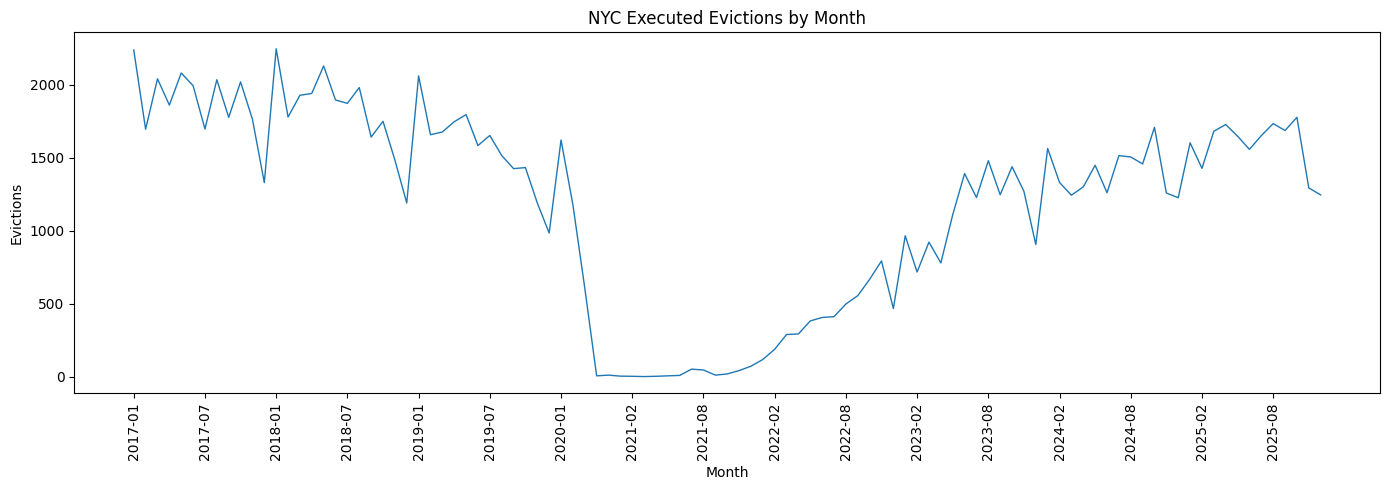

In [4]:
import matplotlib.pyplot as plt

# Parse dates and group by month
df['Executed Date'] = pd.to_datetime(df['Executed Date'])
monthly = df.groupby(df['Executed Date'].dt.to_period('M')).size()

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(monthly.index.astype(str), monthly.values, linewidth=1)
ax.set_xlabel('Month')
ax.set_ylabel('Evictions')
ax.set_title('NYC Executed Evictions by Month')
ax.tick_params(axis='x', rotation=90)
# Show fewer x-axis labels for readability
ax.set_xticks(ax.get_xticks()[::6])
plt.tight_layout()
plt.show()